# Example 3: Fluorescence intensity and shape of phytoplankton cells

In this example we are trying to i) detect phytoplankton cells in 1-channel images (black and white images), ii) measure their pixel-intensities (=fluorescence intensities) and their their shape, and iii) work towards building a classifier for taxonomic groups of phytoplankton. 

The first two objectives are a rather low hanging fruit, as they involve classic computer vision approaches that phenopype can readily supply. The latter goal is more longterm and involves experimenting with classic shape feature detection as provided by phenopype's `shape_features` function (e.g. [image moments](https://docs.opencv.org/3.4/d8/d23/classcv_1_1Moments.html)), and potentially also building up towards a deep learning pipeline usign the contours detected with phenopype. I will update this example as work progresses.  

Images kindly provided by Irene Gallego and Anita Narwani.


<div class="row; text-align: left">
<div class="col-md-6">
<img src="_assets/ex3_before.jpg">

**Input** - Phytoplankton fluorescence. Each sample includes 1 brightfield gray scale image and 3 fluorescence images at different wavelengths.
</div>
<div class="col-md-6">
<img src="_assets/ex3_after.jpg">

**Results** - Phenopype `thresholding` function detects the contours of phytoplankton cells (green) and holes within (red).</div>
</div>


## Approach

All four images show the same objects, but with different pixel intensities. It may be useful to combine information from all images into the segmentation process. This is requires customization of existing workflows in Phenopype, for which the low throughput workflow is best suited: here we have access to intermediate output, and can also integrate low level functions from the `OpenCV` library. Refer to [Tutorial 2](tutorial_2_phenopype_workflow.ipynb) for mor information about the different workflows.

The appraoch is to load all images separately, do segmentation separately, find contours create four binary masks from all contour coordinates, combine the binary masks into a single image, find contours on the binary image.


[1] https://docs.opencv.org/master/d0/d86/tutorial_py_image_arithmetics.html

<center>
<div style="width:800px; text-align: left" >
<img src="_assets/ex3_phyto_layers.png">
    
**Fig. 1:** Each sample includes four images: 1 brightfield (top) and 3 fluorescence measurements (black, bottom). Due to different pigments, not all spcecies are visible in each image, because of different emission spectra. For example, the two long string shaped cells only occur in two of the fluorescence channels, but not the third one or the brightfield. Therefore, including information from all images for segmentation may be useful to get close to the "true" cell count and community composition within a sample. 
    
</div>
</center>

## Low throughput workflow


### Shape descriptors

With the recently (phenopype 1.0.5) introducted `shape_features` function you can measure a set of 43 rotation invariant features from collected contours. However, depending on your case, you may not be able to make use of all feature descriptors since some of them are not scale, rotation or translation invariant. Refer to the documentation `help(pp.measurement.shape_features)` to see which features are useful. 

In our case, phytoplankton are scattered over the image, so we need descriptors that are at least translational and rotational invariants, whereas scale includes relevant descriptive power over phytoplankton of different sizes. Therefore we will use (some) of the basic shape descriptors and the seven Hu moments. 

**NOTE:** This function, like most phenopype functions, is easily expandable. So if you are missing sets of shape descriptors, don't hesitate to contact me with or do a pull request. 

In [1]:
import phenopype as pp

help(pp.measurement.shape_features)

Help on function shape_features in module phenopype.core.measurement:

shape_features(obj_input, df_contours=None, resize=True, resize_to=100, return_basic=True, return_moments=False, return_hu_moments=True)
    Collects a set of 41 shape descriptors from every contour. There are three sets of 
    descriptors: basic shape descriptors, moments, and hu moments. Two additional features,
    contour area and diameter are already provided by the find_contours function.
    https://docs.opencv.org/3.4.9/d3/dc0/group__imgproc__shape.html
    
    Of the basic shape descriptors, all 10 are translational invariants, 8 are rotation 
    invariant (rect_height and rect_width are not) and  4 are also scale invariant 
    (circularity, compactness, roundness, solidity).
    https://en.wikipedia.org/wiki/Shape_factor_(image_analysis_and_microscopy)  
                                
    The moments set encompasses 10 raw spatial moments (some are translation and rotation
    invariants, but not all

First, we load the images.

In [2]:
import os
os.listdir("images")

['cichlid1.jpg',
 'cichlid2.jpg',
 'cichlid3.jpg',
 'cichlid_multi1.jpg',
 'cichlid_multi2.jpg',
 'cichlid_multi3.jpg',
 'isopods.jpg',
 'isopods_fish.mp4',
 'phyto_445.jpg',
 'phyto_469.jpg',
 'phyto_586.jpg',
 'phyto_bright.jpg',
 'snails1.jpg',
 'snails2.jpg',
 'stickle1.JPG',
 'stickle2.JPG',
 'stickle3.JPG',
 'stickleback_side.jpg',
 'stickleback_top.jpg',
 'worms.jpg']

In [3]:
bright, df_bright = pp.load_image("images/phyto_bright.jpg", 
                                  df=True) ## df=True creates a "dataframe-backbone" with meta-data
fl445, df_fl445 = pp.load_image("images/phyto_445.jpg", 
                                df=True)
fl469, df_fl469 = pp.load_image("images/phyto_469.jpg", 
                                df=True)
fl586, df_fl586 = pp.load_image("images/phyto_586.jpg", 
                                df=True)

pp.show_image([bright, fl445, fl469, fl586], max_dim=1000, position_offset=200)

Now the segmentation - note that the brightfield image requires a different method than the fluorescence images, which can be run on the default settings (`method="binary, value=127`). However, they need to be inverted for the algorithm to work (set `invert=True`). 

In [4]:
bright_bin = pp.segmentation.threshold(bright, 
                                       method="adaptive", 
                                       blocksize=299, 
                                       constant=10) 
fl445_bin = pp.segmentation.threshold(fl445, 
                                      invert=True, 
                                      value=127) ## change "value" to increase or decrease sensitivity
fl469_bin = pp.segmentation.threshold(fl469, 
                                      invert=True)
fl586_bin = pp.segmentation.threshold(fl586, 
                                      invert=True)

pp.show_image([bright_bin, fl445_bin, fl469_bin, fl586_bin], max_dim=1000, position_offset=200)

Now we combine all four images into a single array using `OpenCV`'s `add`: https://docs.opencv.org/master/d2/de8/group__core__array.html.

In [5]:
import cv2
comb = cv2.add(bright_bin,fl445_bin)
comb = cv2.add(comb,fl469_bin)
comb = cv2.add(comb,fl586_bin)

pp.show_image([bright_bin, fl445_bin, fl469_bin, fl586_bin, comb], 
              max_dim=1000, 
              position_offset=200)

Back in phenopype, we can detect contours, and calculate the shape features: 

In [6]:
df_contours = pp.segmentation.find_contours(comb)

- found 1030 contours that match criteria


A quick visualization of the found contours reveals that we probably have to detected some contours that are not phytoplankton, but image artefacts. It might be usefull at this point to set a minimum and maximum size in find contours - probably necessary to play around with this to get good results, I don't know enough about these images and phytoplankton.

<AxesSubplot:>

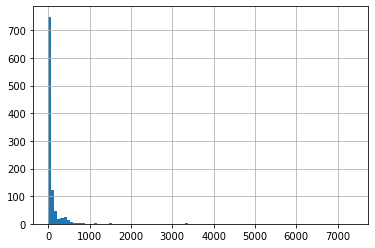

In [7]:
import pandas as pd 

pd.to_numeric(df_contours["area"]).hist(bins=100)

In [8]:
df_contours = pp.segmentation.find_contours(comb, min_area=10, max_area=5000)

- found 575 contours that match criteria


Now the shape features (basic and Hu):

In [9]:
shape_features = pp.measurement.shape_features(df_contours, 
                                               return_hu_moments=True)

Time to visualize and save the results:

In [10]:
viz_check = []

for img, img_df in zip([bright, fl445, fl469, fl586],[df_bright, df_fl445, df_fl469, df_fl586]):
    viz = pp.visualization.draw_contours(img, df_contours, fill=0, line_width=1)
    viz_check.append(viz)
    pp.export.save_canvas(viz, dirpath="_temp/output/ex3", save_suffix=img_df["filename"][0])

- canvas saved under _temp/output/ex3\canvas_phyto_bright.jpg.jpg (overwritten).
- canvas saved under _temp/output/ex3\canvas_phyto_445.jpg.jpg (overwritten).
- canvas saved under _temp/output/ex3\canvas_phyto_469.jpg.jpg (overwritten).
- canvas saved under _temp/output/ex3\canvas_phyto_586.jpg.jpg (overwritten).


In [11]:
pp.show_image(viz_check)

In [12]:
pp.export.save_contours(df_contours, save_coords=False, dirpath="_temp/output/ex3")

- contours saved under _temp/output/ex3\contours.csv (overwritten).


A quick PCA done in R shows that the shapes do separate out (features were centered + scaled). Not sure though why we get this funnel shape...

<center>
<div style="width:600px; text-align: left" >
<img src="_assets/ex3_coords_pca1.png">

</div>
</center> 

### Colour intensities (fluorescence)

We can now use the extracted contours to extract pixel level information from the images. We have used the information from all images to determin the "true" shape, i.e. the space that each cell is occupying in the images. If we now use that information, and apply it back to the original images, we can measure the different intensities with which they fluores.


<center>
<div style="text-align: left" >
<img src="_assets/ex3_colour_intensities.png">
    
**Fig. 2:** The boundaries of all phytoplankton cells were determined using information from all images. Within those contours we can now measure how cells fluores at different wavelengths (not the different intensities within the cells).
    
</div>
</center>

In [13]:
intensities = []

for img, img_df in zip([fl445, fl469, fl586],[df_fl445, df_fl469, df_fl586]):
    intensity = pp.measurement.colour_intensity(img, img_df, df_contours)
    pp.export.save_colours(intensity, dirpath="_temp/output/ex3", save_suffix=img_df["filename"][0])
    intensities.append(intensity)

- colours saved under _temp/output/ex3\colours_phyto_445.jpg.csv (overwritten).
- colours saved under _temp/output/ex3\colours_phyto_469.jpg.csv (overwritten).
- colours saved under _temp/output/ex3\colours_phyto_586.jpg.csv (overwritten).


In [14]:
intensities

[          filename  width  height contour gray_mean   gray_sd
 0    phyto_445.jpg   3135    2132       1         4   1.49241
 1    phyto_445.jpg   3135    2132       2   1.31579   1.45286
 2    phyto_445.jpg   3135    2132       3   8.01163   3.47581
 3    phyto_445.jpg   3135    2132       4   4.53571   2.51872
 4    phyto_445.jpg   3135    2132       5   13.1957   5.85929
 ..             ...    ...     ...     ...       ...       ...
 570  phyto_445.jpg   3135    2132     571      6.12  0.587878
 571  phyto_445.jpg   3135    2132     572   11.0467   6.58572
 572  phyto_445.jpg   3135    2132     573   2.78626  0.873771
 573  phyto_445.jpg   3135    2132     574   12.6949   3.24174
 574  phyto_445.jpg   3135    2132     575  0.330658   0.47045
 
 [575 rows x 6 columns],
           filename  width  height contour gray_mean   gray_sd
 0    phyto_469.jpg   3135    2132       1   29.1136   7.69361
 1    phyto_469.jpg   3135    2132       2   15.3158    3.7424
 2    phyto_469.jpg   3135  

## Implementation

This analysis can probably easiest be conducted within the low throughput workflow, as currently there is no good way to implement it in the low or high throughput workflow. Something like this (in pseudo-code):

In [ ]:
## => create a directory tree where each directory has the 4 images (naming convention)
## => loop over these directories

## for d in dirlist:
##    img = load_image()
##    ...  
##    preprocessing (morphology operation + blur) - shown in example 1 and 5 
##    segmentation 
##    contours
##    shape features
##    colour intensity
##    visualization + export to the same subdir

